## Background
Perusahaan online retial memiliki basis pelanggan dengan karakteristik yang beragam. Dengan keterbatasan sumber daya yang dimiliki perusahaan, perusahaan perlu memahami dan menentukan pelanggan yang memberikan nilai yang besar dalam jangka yang panjang

## Problem Statement
Perusahaan belum memiliki pemahaman yang baik mengenai gambaran nilai pelanggan dalam jangka panjang sehingga strategi pemasaran dan retensi yang dilakukan masih belum optimal

## Objective
Tujuan Analisis ini adalah untuk menghitung dan menganalisis Customer Lifetime Value (CLV) untuk mengidentifikasi pelanggan bernilai tinggi dan merancang strategi retensi yang lebih efektif

## Bussiness Questions
- Pelanggan mana saja yang memiliki CLV tertinggi?
- Bagaimana distribusi CLV di antara pelanggan?
- Strategi apa saja yang cocok untuk setiap kelompok CLV>

In [1]:
import pandas as pd

df = pd.read_csv('Online Retail.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df = df[
    (df['Quantity'] > 0) &
    (df['UnitPrice'] > 0) &
    (~df['InvoiceNo'].str.contains("C"))
]
df = df.dropna(subset = 'CustomerID')

customer_clv_base = df.groupby('CustomerID', as_index=False).agg(
    Total_Revenue = ('Revenue', 'sum'),
    Total_Transaction = ('InvoiceNo', 'nunique'),
    First_Purchase = ('InvoiceDate', 'min'),
    Last_Purchase = ('InvoiceDate', 'max')
)

customer_clv_base['AOV'] = (
    customer_clv_base['Total_Revenue'] / customer_clv_base['Total_Transaction']
)

customer_clv_base['Customer_Lifetime'] = (
    customer_clv_base['Last_Purchase'] - customer_clv_base['First_Purchase'] 
).dt.days

customer_clv_base = customer_clv_base[
    [
        'CustomerID',
        'Total_Revenue',
        'Total_Transaction',
        'AOV',
        'First_Purchase',
        'Last_Purchase',
        'Customer_Lifetime'
    ]
]

customer_clv_base['Customer_Lifetime_Months'] = (
    customer_clv_base['Customer_Lifetime'] / 30
).round(1)

customer_clv_base = customer_clv_base[
    customer_clv_base['Customer_Lifetime_Months'] > 0
]

customer_clv_base['Purchase_Frequency'] = (
    customer_clv_base['Total_Transaction'] / customer_clv_base['Customer_Lifetime_Months']
)

customer_clv_base['CLV'] = (
    customer_clv_base['AOV'] * 
    customer_clv_base['Purchase_Frequency'] *
    customer_clv_base['Customer_Lifetime_Months']
)


q50 = customer_clv_base['CLV'].quantile(0.50)
q80 = customer_clv_base['CLV'].quantile(0.80)

def clv_segment(value):
    if value <= q50:
        return 'Low Value'
    elif value <= q80:
        return 'Mid Value'
    else:
        return 'High Value'

customer_clv_base['CLV_Segment'] = customer_clv_base['CLV'].apply(clv_segment)

customer_clv_base

,CustomerID,Total_Revenue,Total_Transaction,AOV,First_Purchase,Last_Purchase,Customer_Lifetime,Customer_Lifetime_Months,Purchase_Frequency,CLV,CLV_Segment
1,12347.0,4310.00,7,615.714286,2010-12-07 14:57:00,2011-12-07 15:52:00,365,12.2,0.573770,4310.00,High Value
2,12348.0,1797.24,4,449.310000,2010-12-16 19:09:00,2011-09-25 13:13:00,282,9.4,0.425532,1797.24,Mid Value
5,12352.0,2506.04,8,313.255000,2011-02-16 12:33:00,2011-11-03 14:37:00,260,8.7,0.919540,2506.04,Mid Value
9,12356.0,2811.43,3,937.143333,2011-01-18 09:50:00,2011-11-17 08:40:00,302,10.1,0.297030,2811.43,Mid Value
11,12358.0,1168.06,2,584.030000,2011-07-12 10:04:00,2011-12-08 10:26:00,149,5.0,0.400000,1168.06,Low Value
...,...,...,...,...,...,...,...,...,...,...,...
4327,18272.0,3078.58,6,513.096667,2011-04-07 09:35:00,2011-12-07 12:43:00,244,8.1,0.740741,3078.58,High Value
4328,18273.0,204.00,3,68.000000,2011-03-27 11:22:00,2011-12-07 13:16:00,255,8.5,0.352941,204.00,Low Value
4335,18282.0,178.05,2,89.025000,2011-08-05 13:35:00,2011-12-02 11:43:00,118,3.9,0.512821,178.05,Low Value
4336,18283.0,2094.88,16,130.930000,2011-01-06 14:14:00,2011-12-06 12:02:00,333,11.1,1.441441,2094.88,Mid Value


**Catatan:**

CLV pada analisis ini dihitung menggunakan pendekatan historical CLV, di mana nilai CLV merepresentasikan total nilai transaksi pelanggan selama periode observasi. Oleh karena itu, nilai CLV secara matematis setara dengan total revenue per pelanggan. Pendekatan ini digunakan untuk memahami nilai historis pelanggan dan keperluan segmentasi strategis, bukan sebagai prediksi nilai di masa depan.


In [3]:
customer_clv_base.groupby(['CLV_Segment']).agg(
    Total_Customer=('CustomerID', 'count'),
    Avg_CLV=('CLV', 'mean'),
    Total_Revenue=('CLV','sum')
)

,Total_Customer,Avg_CLV,Total_Revenue
CLV_Segment,,,
High Value,556,10303.236081,5728599.261
Low Value,1389,640.056697,889038.752
Mid Value,832,1886.737620,1569765.700


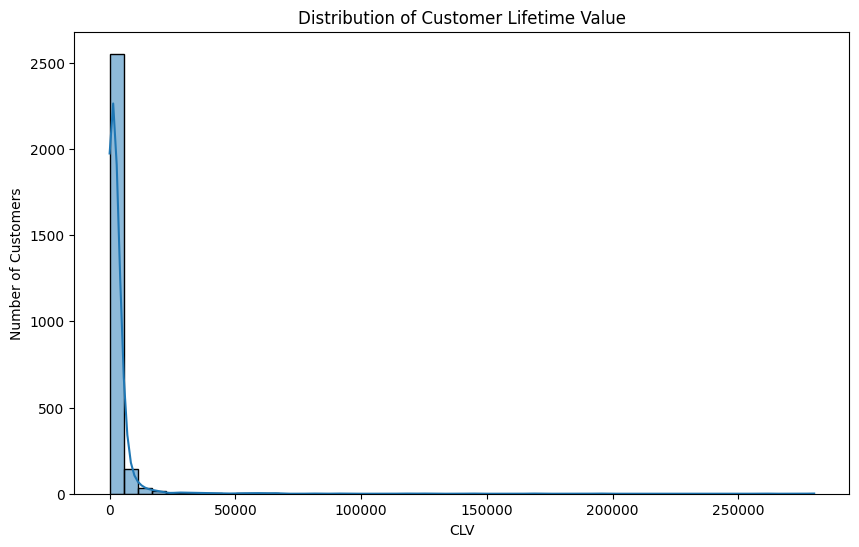

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(customer_clv_base['CLV'], bins=50, kde=True)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('CLV')
plt.ylabel('Number of Customers')
plt.show()


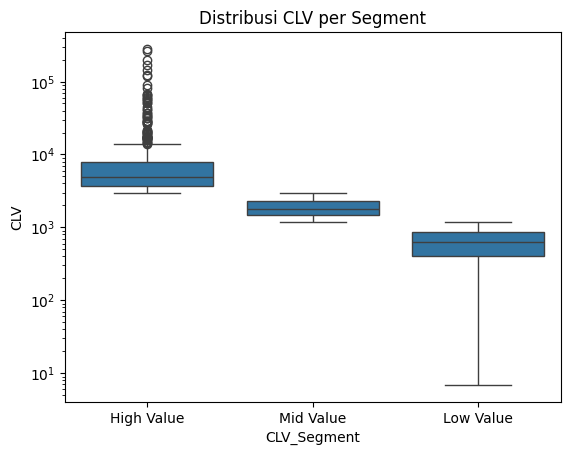

In [40]:
sns.boxplot(
    data=customer_clv_base,
    x='CLV_Segment',
    y='CLV'
)
plt.yscale('log')
plt.title("Distribusi CLV per Segment")
plt.show()

## Executive summary

Analisis Customer Lifetime Value (CLV) bertujuan untuk memahami kontribusi nilai pelanggan terhadap perusahaan retail online pada periode 2010–2011. Melalui proses data cleaning, exploratory data analysis (EDA), dan perhitungan CLV berbasis nilai historis, pelanggan dikelompokkan ke dalam tiga segmen utama: High Value, Mid Value, dan Low Value berdasarkan total kontribusi pendapatan.

Hasil analisis menunjukkan bahwa segmen pelanggan bernilai tinggi memberikan kontribusi yang sangat signifikan terhadap total pendapatan perusahaan, meskipun jumlah pelanggan pada segmen ini relatif paling sedikit. Temuan ini menegaskan bahwa strategi yang berfokus pada pengembangan dan retensi pelanggan bernilai tinggi lebih efektif dibandingkan pendekatan promosi massal.

Insight dari analisis ini diharapkan dapat membantu perusahaan dalam menyusun strategi pemasaran yang lebih efisien, meningkatkan loyalitas pelanggan, serta memaksimalkan nilai jangka panjang dari setiap segmen pelanggan.


## Key Insight
- Distribusi CLV yang menunjukkan pola yang tidak merata (right-skewed) dari ketiga segmen yang ada, dengan didominasi oleh segmen pelanggan dengan nilai CLV yang cenderung rendah
- Pelanggan dengan High Value memiliki jumlah yang rendah, namun berkontribusi tinggi terhadap proporsi total revenue hingga 65%
- Disisi lain Pelanggan dengan Low Value memiliki jumlah yang lebih banyak, namun kontribusinya terhadap total revenue relatif kecil
- Perbedaan kontribusi juga memberikan pemahaman bahwa setiap pelanggan memiliki dampak yang berbeda dari sudut pandang bisnis terhdap perusahaan


## Bussiness Recomendation
1. Fokuskan strategi terhadap High Value melalui program loyalitas, penawaran ekslusif, dan layanan prioritas untuk menjada kontrbusi utama terhadap perusahaan
2. Kembangkan Mid Value untuk mendorong frequensi transaksi dengan kampanye personalisasi dan bundling
3. Terapkan pemasaran yang selektif terhadap Low Value dengan promosi berbiaya rendah dan otomatisasi pemasaran untuk mengefisienkan biaya
4. Evaluasi strategi akuisisi pelanggan baru yang berorientasi kepada kualitas, bukan hanya kuantitas, dengan mengacu pada karakteristik pelanggan dengan nilai tinggi

## Conclution

Analisis CLV memberikan gambaran yang jelas mengenai perbedaan nilai pelanggan terhadap bisnis. Dengan menggunakan pendekatan CLV historis, perusahaan dapat mengidentifikasi pelanggan bernilai tinggi dan menyusun strategi pemasaran yang lebih terarah.

Meskipun analisis ini belum mempertimbangkan prediksi nilai pelanggan di masa depan, hasil yang diperoleh tetap relevan sebagai dasar pengambilan keputusan strategis. Pengembangan lebih lanjut dapat dilakukan dengan mengintegrasikan model prediktif CLV untuk mendukung perencanaan jangka panjang perusahaan.
